<a href="https://colab.research.google.com/github/netomap/flower_classification_/blob/master/Flower_Class_with_transfer_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classificação de flores utilizando transferLearning e salvando o modelo para reaproveitá-lo em outros dispositivos.

In [29]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import random
import time

In [2]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly

     |████████████████████████████████| 112kB 9.5MB/s 
     |████████████████████████████████| 3.4MB 13.4MB/s 


In [3]:
#importando a base de dados de flores
data_dir = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)

228818944/228813984 [==============================] - 5s 0us/step


In [4]:
DIRETORIO = pathlib.Path(data_dir)

In [5]:
list_images = list(DIRETORIO.glob('*/*.jpg'))
print ('{} imagens no diretorio'.format(len(list_images)))

3670 imagens no diretorio


In [6]:
# pegando as classes dentro do diretorio
classes = list(DIRETORIO.glob('*'))
class_names = np.array([item.name for item in classes if item.name != 'LICENSE.txt'])
print (class_names)

['sunflowers' 'daisy' 'roses' 'tulips' 'dandelion']


In [28]:
BATCH_SIZE = 32
SIZE = 224

# criando um image_data_generator para treino e validação
image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20, 
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    validation_split = 0.1
)

train_data_generator = image_data_generator.flow_from_directory(
    directory = DIRETORIO,
    target_size = (SIZE, SIZE),
    classes = list(class_names),
    batch_size = BATCH_SIZE,
    shuffle = True,
    subset = 'training'
)

validation_data_generator = image_data_generator.flow_from_directory(
    directory = DIRETORIO,
    target_size = (SIZE, SIZE),
    classes = list(class_names),
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

STEPS_TRAIN = train_data_generator.n // train_data_generator.batch_size
STEPS_VALIDATION = validation_data_generator.n // validation_data_generator.batch_size

print ('STEPS TRAIN: {} e STEPS_VALIDATION: {}'.format(STEPS_TRAIN, STEPS_VALIDATION))

Found 3306 images belonging to 5 classes.
Found 364 images belonging to 5 classes.
STEPS TRAIN: 103 e STEPS_VALIDATION: 11


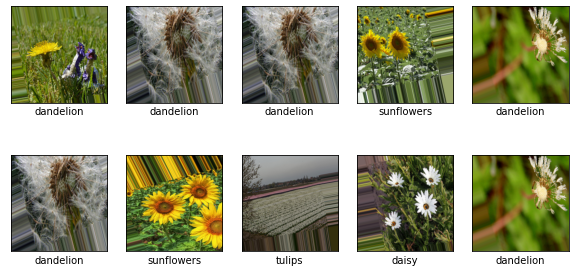

In [9]:
# um simples teste para vericar as fotos randomicamente do train data generator e validation data generator

images, labels = next(validation_data_generator)
plt.figure(figsize=(10, 5))
for k in range(10):
  plt.subplot(2, 5, k+1)
  n = random.randint(0, len(images)-1)
  plt.imshow(images[n])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(class_names[np.argmax(labels[n])])
plt.show()

In [10]:
# importando a rede neural já treinada ImageNet
url_rede_treinada = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'

rede_treinada = hub.KerasLayer(url_rede_treinada)

# definindo que esta camada importada não sera treinada
rede_treinada.trainable = False

In [11]:
# criando o modelo

model = keras.Sequential()

model.add(rede_treinada)

model.add(keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
EPOCHS = 5

history = model.fit_generator(
    generator = train_data_generator,
    steps_per_epoch = STEPS_TRAIN,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = validation_data_generator,
    validation_steps = STEPS_VALIDATION,
    shuffle = True
)

Epoch 1/5
103/103 [==============================] - 45s 439ms/step - loss: 0.3708 - accuracy: 0.8708 - val_loss: 0.5063 - val_accuracy: 0.8352
Epoch 2/5
103/103 [==============================] - 46s 443ms/step - loss: 0.3216 - accuracy: 0.8855 - val_loss: 0.4301 - val_accuracy: 0.8722
Epoch 3/5
103/103 [==============================] - 45s 441ms/step - loss: 0.3148 - accuracy: 0.8861 - val_loss: 0.4912 - val_accuracy: 0.8409
Epoch 4/5
103/103 [==============================] - 45s 442ms/step - loss: 0.3002 - accuracy: 0.8925 - val_loss: 0.4441 - val_accuracy: 0.8409
Epoch 5/5
103/103 [==============================] - 45s 440ms/step - loss: 0.2856 - accuracy: 0.9004 - val_loss: 0.4467 - val_accuracy: 0.8551
Epoch 1/5
103/103 [==============================] - 46s 443ms/step - loss: 0.2813 - accuracy: 0.8989 - val_loss: 0.4685 - val_accuracy: 0.8409
Epoch 2/5
103/103 [==============================] - 46s 443ms/step - loss: 0.2753 - accuracy: 0.8986 - val_loss: 0.5018 - val_accuracy:

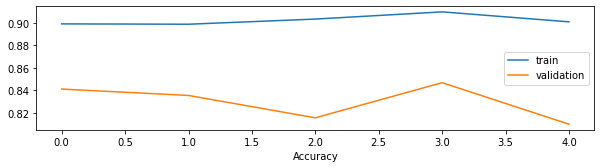

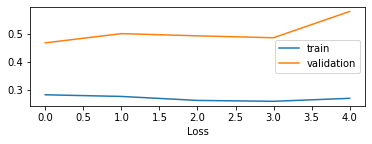

In [27]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(range(EPOCHS), train_accuracy, label='train')
plt.plot(range(EPOCHS), validation_accuracy, label='validation')
plt.legend()
plt.xlabel('Accuracy')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(range(EPOCHS), train_loss, label='train')
plt.plot(range(EPOCHS), validation_loss, label='validation')
plt.legend()
plt.xlabel('Loss')
plt.show()

In [33]:
# SALVANDO O MODELO TREINADO
t = time.time()

export_path = "/content/drive/My Drive/Colab Notebooks/Transfer_Learning_Test/modelo_TRANSFER_LEARNING"
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Transfer_Learning_Test/modelo_TRANSFER_LEARNING/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Transfer_Learning_Test/modelo_TRANSFER_LEARNING/assets


'/content/drive/My Drive/Colab Notebooks/Transfer_Learning_Test/modelo_TRANSFER_LEARNING'

In [34]:
modelo_salvo = keras.models.load_model(export_path)

In [35]:
modelo_salvo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  1280      
_________________________________________________________________
dense (Dense)                multiple                  5010      
Total params: 6,290
Trainable params: 5,010
Non-trainable params: 1,280
_________________________________________________________________


In [36]:
# subindo algumas figuras para o drive para teste final do modelo salvo
diretorio_teste = '/content/drive/My Drive/Colab Notebooks/Transfer_Learning_Test/figuras'
diretorio_teste = pathlib.Path(diretorio_teste)
diretorio_teste

PosixPath('/content/drive/My Drive/Colab Notebooks/Transfer_Learning_Test/figuras')

In [37]:
# colocando as imagens num vetor para depois tratar seus dados.
images_test = list(diretorio_teste.glob('*'))
print ('{} imagens no diretorio para teste.'.format(len(images_test)))

17 imagens no diretorio para teste.


In [43]:
# preparando os dados para uma matriz com [n, 224, 224, 3]
image_data = []
for imagem in images_test:
  img = Image.open(imagem)
  img = img.resize((SIZE, SIZE))
  data_ = np.array(img.getdata()).reshape((SIZE, SIZE, 3))*(1./255)
  image_data.append(data_)

image_data = np.array(image_data)
image_data.shape

(17, 224, 224, 3)

In [44]:
predictions = modelo_salvo.predict(image_data)

In [54]:
label_predictions = []
for vetor in predictions:
  label = class_names[np.argmax(vetor)]
  percent = 100*np.max(vetor)
  label_predictions.append('{:0.0f}% {}'.format(percent, label))

label_predictions = np.array(label_predictions)
print (label_predictions)

['52% daisy' '99% daisy' '100% daisy' '99% sunflowers' '96% sunflowers'
 '100% dandelion' '100% dandelion' '99% sunflowers' '88% sunflowers'
 '100% dandelion' '100% tulips' '100% tulips' '89% roses' '60% tulips'
 '100% tulips' '64% roses' '98% daisy']


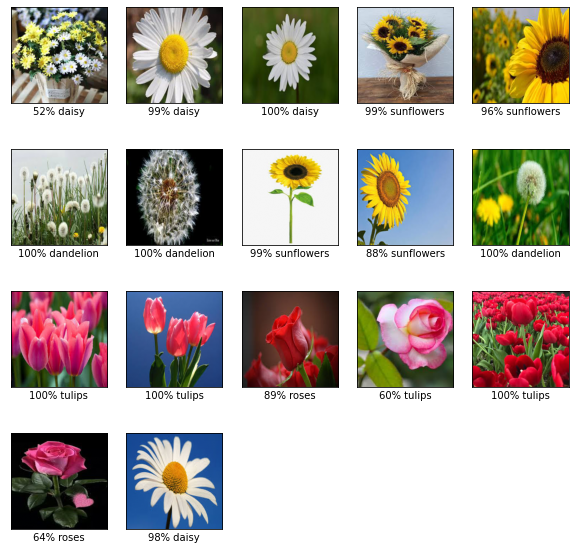

In [55]:
plt.figure(figsize=(10, 10))
for k in range(17):
  plt.subplot(4, 5, k+1)
  plt.imshow(image_data[k])
  plt.xlabel(label_predictions[k])
  plt.xticks([])
  plt.yticks([])
plt.show()

In [50]:
predicao_1 = model.predict(image_data) # predição feita pelo modelo que foi treinado inicialmente

In [51]:
diferenca = predicao_1 - predictions # diferença entre as predições do modelo treinado e modelo importado

In [52]:
print (np.max(diferenca)) # como esperado, não há diferença entre os modelos.

0.0
